In [16]:
# imports

import os
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import wandb
import yaml
from easydict import EasyDict
from tqdm import tqdm
import monai
import torch.nn as nn
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry

from model import RadSam
from dataset import RadSamDataset

join = os.path.join


In [17]:
# CONFIG =============================
# Load YAML config file
with open('config.yaml', 'r') as file:
    config_dict = yaml.safe_load(file)

config = EasyDict(config_dict)
run_id = datetime.now().strftime("%Y%m%d-%H%M")
device = config.training.device
model_save_path = join(config.model.work_dir, config.model.task_name + "-" + run_id)
os.makedirs(model_save_path, exist_ok=True)
# ====================================

In [18]:
print(device)

mps


In [19]:
# MODEL ==============================
sam_model = sam_model_registry[config.training.model_type](checkpoint=config.training.checkpoint)
radsam_model = RadSam(
    image_encoder=sam_model.image_encoder,
    mask_decoder=sam_model.mask_decoder,
    prompt_encoder=sam_model.prompt_encoder,
    freeze_img_encoder=True
).to(device)

print("Number of total parameters: ", sum(p.numel() for p in radsam_model.parameters())) 
print("Number of trainable parameters: ", sum(p.numel() for p in radsam_model.parameters() if p.requires_grad))  # 93729252

img_mask_encdec_params = list(radsam_model.image_encoder.parameters()) + list(
    radsam_model.mask_decoder.parameters()
)
optimizer = torch.optim.AdamW(
    img_mask_encdec_params, lr=config.training.lr, weight_decay=config.training.weight_decay
)

# optimizer
img_mask_encdec_params = list(radsam_model.image_encoder.parameters()) + list(
    radsam_model.mask_decoder.parameters()
)
optimizer = torch.optim.AdamW(
    img_mask_encdec_params, lr=config.training.lr, weight_decay=config.training.weight_decay
)

# loss
seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction="mean")
ce_loss = nn.BCEWithLogitsLoss(reduction="mean")
# ====================================

Number of total parameters:  93735472
Number of trainable parameters:  4058340


In [20]:
# DATASET ============================
num_epochs = config.training.num_epochs
iter_num = 0
losses = []
best_loss = 1e10
train_dataset = RadSamDataset(
    config.dataset.img_dir,
    config.dataset.masks_path,
    config.dataset.pnts_path,
    config.dataset.start_idx,
    config.dataset.end_idx
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.training.batch_size,
    shuffle=True,
    num_workers=config.training.num_workers,
    pin_memory=True,
)
# ====================================

In [ ]:
# TRAINING ===========================
start_epoch = 0
if config.training.resume is not None:
    if os.path.isfile(config.training.resume):
        ## Map model to be loaded to specified single GPU
        checkpoint = torch.load(config.training.resume, map_location=device)
        start_epoch = checkpoint["epoch"] + 1
        radsam_model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])

for epoch in range(start_epoch, num_epochs):
    epoch_loss = 0
    for step, (img_batch, points, masks, _) in enumerate(tqdm(train_dataloader)):
        
        img_batch = img_batch.to(device)
        points = [points[0].to(device), points[1].to(device)]
        masks = masks.to(device)

        optimizer.zero_grad()
        medsam_pred, _ = radsam_model(img_batch, points)
        medsam_pred = medsam_pred.squeeze().unsqueeze(0)
        loss = seg_loss(medsam_pred, masks) + ce_loss(medsam_pred, masks.float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        iter_num += 1
    
    epoch_loss /= step
    losses.append(epoch_loss)


    # VALIDATION =========================

    # ====================================


    # LOGGING ============================
    if config.training.use_wandb:
        wandb.log({"epoch_loss": epoch_loss})
    print(
        f'Time: {datetime.now().strftime("%Y%m%d-%H%M")}, Epoch: {epoch}, Loss: {epoch_loss}'
    )
    # save the latest model
    checkpoint = {
        "model": medsam_pred.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
    }
    torch.save(checkpoint, join(model_save_path, "medsam_model_latest.pth"))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        checkpoint = {
            "model": medsam_pred.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
        }
        torch.save(checkpoint, join(model_save_path, "medsam_model_best.pth"))
    # ====================================



  6%|▌         | 188/3009 [02:44<41:08,  1.14it/s]


KeyboardInterrupt: 

In [65]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# sam_checkpoint = "/Users/eustachelebihan/Downloads/sam_vit_b_01ec64.pth"
model_type = "vit_b"
# model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
model = sam_model_registry[model_type]()


model.image_encoder = radsam_model.image_encoder
model.mask_decoder = radsam_model.mask_decoder
model.prompt_encoder = radsam_model.prompt_encoder

model.to(device="cpu")

mask_generator = SamAutomaticMaskGenerator(model)

In [66]:
import cv2

img_path = '/Users/eustachelebihan/Development/radium-challenge/data/x-train/0.png'
image = cv2.imread(img_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [76]:
masks = mask_generator.generate(image)

In [ ]:
masks_s = sorted(masks, key=(lambda x: x['area']), reverse=True)
len(masks)

30

In [ ]:
import numpy as np

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.zeros(([0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1]))
    img[:,:,3] = 0
    i = 1
    for ann in sorted_anns:
        m = ann['segmentation']
        img[m] = i
        i += 1
    print(img[0,0])
    ax.imshow(img)

<>:10: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
<>:10: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
/var/folders/9f/37t44p7s00nc2jsnwh7n_4k40000gn/T/ipykernel_96270/3285903613.py:10: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  img = np.zeros(([0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1]))


TypeError: list indices must be integers or slices, not str

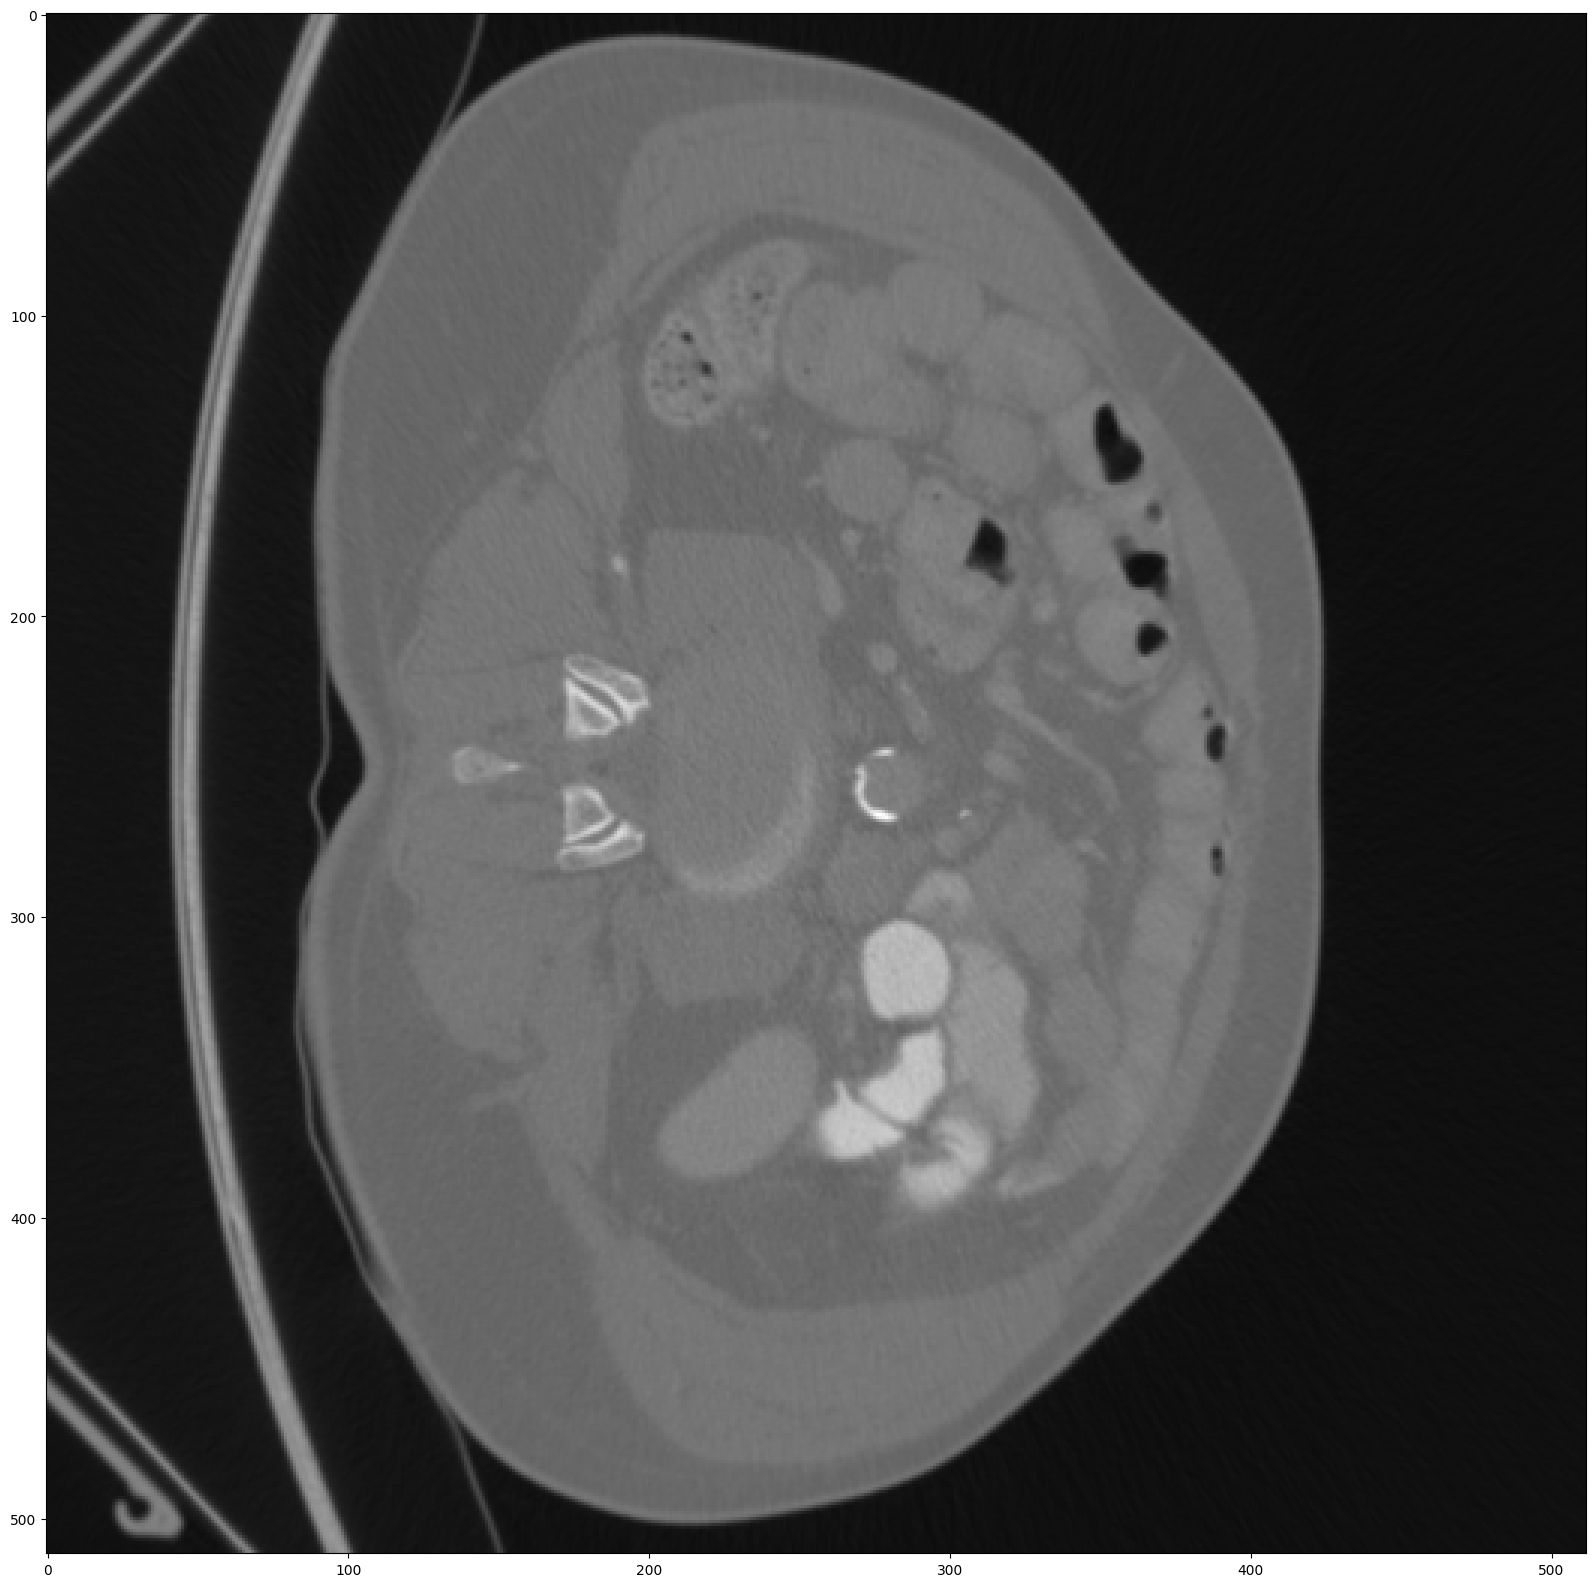

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:
import numpy as np

def show_anns(anns):
    if len(anns) == 0:
        return
    
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    mask = np.zeros((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1]))
    
    i = 1
    for ann in sorted_anns:
        m = ann['segmentation']
        mask[m] = i
        i += 1

    return mask


In [ ]:
m = show_anns(masks)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed